In [245]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import soundfile as sf
from pathlib import Path
import re
import json
from pathlib import Path

# Read metadata

In [266]:
file_path = 'PATH_2_WAV_ICML2013'
artifcats_path = '/home/z30g0d/PycharmProjects/temp/trains/' #Artifact path

In [267]:
file_path_obj = Path(file_path)

In [268]:
all_files = list(file_path_obj.glob('*.wav'))

In [269]:
n_files = len(all_files)

In [270]:
sf.info(all_files[0]).duration

2.0

In [271]:
duration_vec = np.array([float(sf.info(file).duration) for file in all_files]).reshape((-1,1))

In [272]:
annotation_df = pd.DataFrame(data=np.concatenate([np.ones((n_files, 1))*0, duration_vec, 
                                                  np.array([all_files[i].stem for i in range(n_files)]).reshape((-1,1)),
                                                  duration_vec,
                                                  np.array([int(file.stem[-1]) for file in all_files]).reshape((-1,1))],axis=1),
                             columns=['begin_time', 'end_time', 'filename', 'call_length', 'label'])

In [273]:

annotation_df = annotation_df.astype({'begin_time': 'float64', 'end_time':'float64', 'call_length':'float64',
                                     'label':'int32'})


In [274]:
annotation_df

,begin_time,end_time,filename,call_length,label
0,0.0,2.0,20090328_000000_010s8ms_TRAIN1_0,2.0,0
1,0.0,2.0,20090328_000000_068s4ms_TRAIN4_0,2.0,0
2,0.0,2.0,20090328_001500_1397s8ms_TRAIN216_1,2.0,1
3,0.0,2.0,20090328_000000_002s3ms_TRAIN0_0,2.0,0
4,0.0,2.0,20090328_001500_1379s8ms_TRAIN214_1,2.0,1
5,0.0,2.0,20090328_001500_1374s4ms_TRAIN213_1,2.0,1


In [275]:
annotation_df[annotation_df.call_length > 1.65].to_csv('SAVE_ALL_ANOTTATIONS', index=False)

In [276]:
annotation_df.label.value_counts()

0    3
1    3
Name: label, dtype: int64

# Show sample

In [277]:
annotation_df = pd.read_csv('SAVE_ALL_ANOTTATIONS')

In [278]:
import random
import librosa
from librosa import display
import IPython.display as ipd
import matplotlib.pyplot as plt
import wave
%matplotlib inline

In [279]:
def play_audio_plot_stft(df_series, audio_path):
    def get_sr(wav_path):
        with wave.open(str(wav_path), "rb") as wave_file:
            return wave_file.getframerate()
    
    def play_audio(audio_data, sr):
        ipd.display(ipd.Audio(audio_data, rate=sr))
    
    def plot_stft(audio_data, sr):
        plt.figure(figsize=(15,7))
        nfft = 256
        D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data, n_fft=nfft, hop_length=nfft // 4)), ref=np.max)
        display.specshow(D, sr=sr, fmax=10000)
        plt.colorbar(format='%+2.0f dB')
    
    audio_file_path = (audio_path + df_series['filename'] + '.wav')
    start_time = df_series['begin_time']
    end_time = df_series['end_time']
    sr = get_sr(audio_file_path)
    audio_data, sr = sf.read(audio_file_path, start=int(start_time*sr), stop=int(end_time*sr))
    
    play_audio(audio_data, sr)
    plot_stft(audio_data, sr)
    plt.title(df_series['filename'] + ' ' + str(df_series['label']))

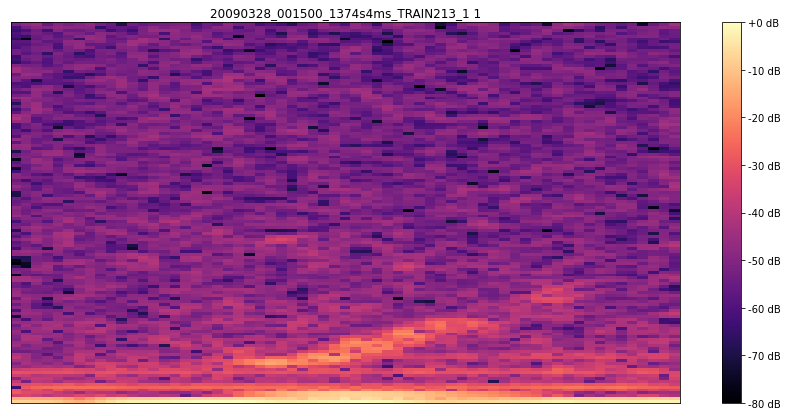

In [280]:
play_audio_plot_stft(annotation_df.sample(1).T.squeeze(), file_path)

# split

In [281]:
day = annotation_df.filename.str[6:8].astype(int)

In [282]:
annotation_df

,begin_time,end_time,filename,call_length,label
0,0.0,2.0,20090328_000000_010s8ms_TRAIN1_0,2.0,0
1,0.0,2.0,20090328_000000_068s4ms_TRAIN4_0,2.0,0
2,0.0,2.0,20090328_001500_1397s8ms_TRAIN216_1,2.0,1
3,0.0,2.0,20090328_000000_002s3ms_TRAIN0_0,2.0,0
4,0.0,2.0,20090328_001500_1379s8ms_TRAIN214_1,2.0,1
5,0.0,2.0,20090328_001500_1374s4ms_TRAIN213_1,2.0,1


In [283]:
day.value_counts()

28    6
Name: filename, dtype: int64

In [284]:
annotation_df[day == 28]['label'].value_counts()/(day == 28).sum()

0    0.5
1    0.5
Name: label, dtype: float64

In [285]:
annotation_df[day == 29]['label'].value_counts()/(day == 29).sum()

Series([], Name: label, dtype: float64)

In [286]:
annotation_df[day == 30]['label'].value_counts()/(day == 30).sum()

Series([], Name: label, dtype: float64)

In [295]:
annotation_df[day == 31]['label'].value_counts()/(day == 31).sum()

Series([], Name: label, dtype: float64)

In [296]:
annotation_df[day == 28].to_csv(artifcats_path + 'annotation_train2_test.csv', index=False)

In [297]:
annotation_df[day == 30].to_csv(artifcats_path + 'annotation_train2_val.csv', index=False)

In [298]:
annotation_df[day.isin([29,31])].to_csv(artifcats_path + 'annotation_train2_train.csv', index=False)

## split chrisoph like

In [299]:
ratio_train = 42 / (42 + 5)

In [300]:
ratio_train

0.8936170212765957

In [301]:
christ_train_annotation_df = annotation_df.iloc[:int(ratio_train*annotation_df.shape[0]), :]
christ_test_annotation_df = annotation_df.iloc[int(ratio_train*annotation_df.shape[0]):, :]

In [302]:
christ_train_annotation_df.to_csv(artifcats_path + 'annotation_train2_christoph_train.csv', index=False)
christ_test_annotation_df.to_csv(artifcats_path + 'annotation_train2_christoph_test.csv', index=False)